<a href="https://colab.research.google.com/github/WenxiGu/text-mining/blob/main/Wenxi_Gu_ejercicio1_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.9.2 which is incompatible.


In [2]:
!pip -q install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 72.6 MB/s eta 0:00:00



⚙️ **Requerimientos importantes sobre el ejercicio**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.



## Imports

In [3]:
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Add your imports here

import os, random, numpy as np, torch, platform
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
set_seed(42)

import transformers, datasets, evaluate
print("Py:", platform.python_version())
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)

Py: 3.12.12
torch: 2.9.0+cu126
transformers: 4.57.3
datasets: 4.0.0


Transformers 是高层库，PyTorch 是底层引擎。

PyTorch 提供张量、自动求导、优化器、GPU 加速等“地基”。

Transformers 基于这些地基，实现了 BERT/Roberta/XLM-R 等模型封装、分词器、Trainer等“上层建筑”。

# 🔍 Ejercicio1: Detección de profesiones en tweets

## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completarás las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de tarea a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

📝 **Criterios de Evaluación**

Tu trabajo será evaluado según los siguientes criterios:

| Criterio                                            | Peso  |
|-----------------------------------------------------|--------|
| 🔍 Análisis exploratorio y preprocesamiento         | 20%   |
| 🤖 Selección y justificación del modelo             | 25%   |
| 📁 Formato y validez del archivo de predicciones    | 5%    |
| ⚙️ Ejecución correcta del notebook (sin intervención) | 10%   |
| 📈 Rendimiento del modelo sobre el conjunto de test | 30%   |
| ✍️ Claridad y calidad de las explicaciones          | 10%   |



🔔 **Nota importante:**

> El rendimiento del modelo se evaluará utilizando métricas estándar como el **F1-score** sobre el conjunto de test.

> El archivo de predicciones debe respetar **estrictamente** el formato solicitado (`id` y `label`, separados por tabulador y con extensión `.tsv`).  
  ❗ Si el archivo no cumple con este formato, **el ejercicio no podrá ser evaluado en esa sección**.

> El/la estudiante con el **mayor F1-score** obtendrá la puntuación máxima en el apartado de rendimiento. El resto de calificaciones se ajustarán de forma proporcional al mejor resultado



⚙️ **Requerimientos y reglas**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.


# Tu resolución (rellena las celdas marcadas)

## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [ ]:
#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [6]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

In [7]:
dataset_train_df.head()

,tweet_id,text,label
0,1275401361073586177,Las / os sanitarias / os no necesitan capas de...,1
1,1251580665948246023,Las residencias de mayores de Burgos suman 42 ...,0
2,1244272146265903106,@IreneMontero Utilice el tiempo de confinamien...,0
3,1263384060132495360,.@FreseniusKabi dona más de 110.000 mascarilla...,1
4,1250207505252265989,Judy y el confinamiento . Dia 31 . Mona de Pas...,0


**Número de documentos**

Obten con la función `get_num_docs_evaluation()` el número de documentos del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [8]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  num_docs = len(dataset_df)
  # No modifiques el return
  return num_docs


Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [9]:
# Aplica la función

n_train = get_num_docs_evaluation(dataset_train_df)
n_val   = get_num_docs_evaluation(dataset_val_df)
n_test  = get_num_docs_evaluation(dataset_test_df)

print(f"Train docs: {n_train}")
print(f"Validation docs: {n_val}")
print(f"Test docs: {n_test}")


Train docs: 2786
Validation docs: 999
Test docs: 1001


**Número de documentos duplicados**

Obten con la función `detect_duplicates_evaluation()` el número de documentos duplicados del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [10]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):
  # Modifica la función.
  num_total = len(dataset_df)
  num_unique = dataset_df['text'].astype(str).drop_duplicates().shape[0]
  num_duplicates = num_total - num_unique
  # No modifiques el return
  return num_duplicates

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [11]:
# Aplica la función
dup_train = detect_duplicates_evaluation(dataset_train_df)
dup_val   = detect_duplicates_evaluation(dataset_val_df)
dup_test = detect_duplicates_evaluation(dataset_test_df)

print(f"Duplicados en TRAIN: {dup_train}")
print(f"Duplicados en VALIDATION: {dup_val}")
print(f"Duplicados en TEST: {dup_test}")

Duplicados en TRAIN: 0
Duplicados en VALIDATION: 0
Duplicados en TEST: 0


**Número de documentos por cada clase:**


Obten con la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [12]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  # Modifica la función.
  num_positives = int((dataset_df['label'] == 1).sum())
  num_negatives = int((dataset_df['label'] == 0).sum())

  # vc = dataset_df['label'].value_counts()
  # num_positives = int(vc.get(1, 0))
  # num_negatives = int(vc.get(0, 0))

  # No modifiques el return
  return num_positives, num_negatives

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [13]:
# Aplica la función

pos_tr, neg_tr = analyse_num_labels_evaluation(dataset_train_df)
pos_va, neg_va = analyse_num_labels_evaluation(dataset_val_df)
print(f"Train pos/neg = {pos_tr}/{neg_tr}")
print(f"Val   pos/neg = {pos_va}/{neg_va}")


Train pos/neg = 1393/1393
Val   pos/neg = 238/761


**Distribución de la longitud de los tweet en caracteres:**

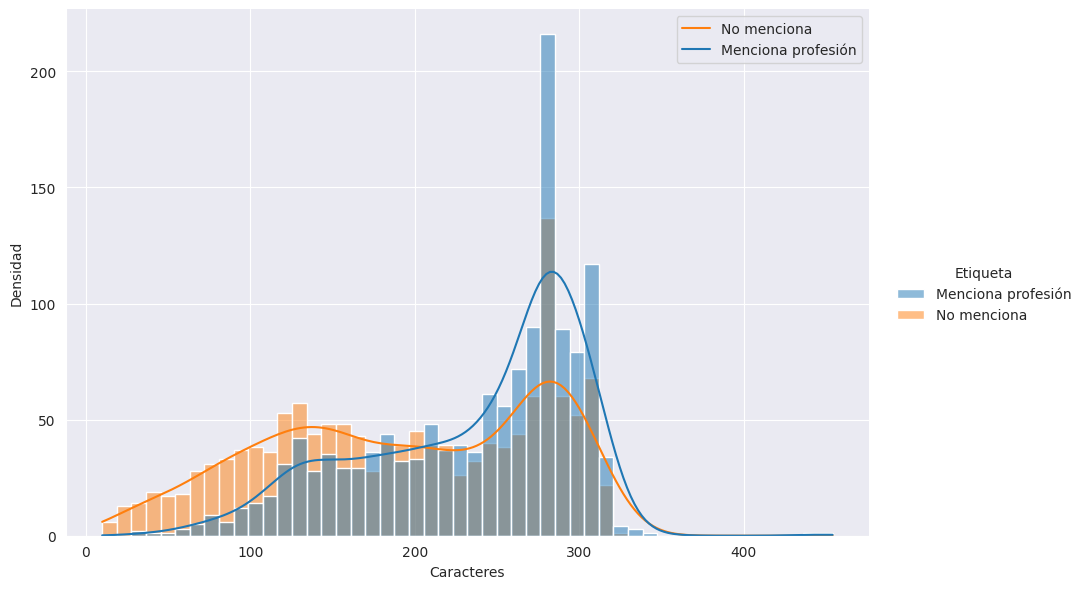

Train mean: 215.05743000717874
Train median: 235.0
Train p95: 308.0


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = dataset_train_df.copy()
df["char_len"] = df["text"].astype(str).str.len()
df["label_txt"] = df["label"].map({0: "No menciona", 1: "Menciona profesión"})


#plot
sns.set_style("darkgrid")
g = sns.displot(
    data=df,
    x="char_len",
    hue="label_txt",
    kind="hist",
    kde=True,
    legend=True,
    bins=50,
    height=6,
    aspect=1.5,
)

plt.legend(["No menciona", "Menciona profesión"])
g.set_xlabels("Caracteres")
g.set_ylabels("Densidad")
g._legend.set_title("Etiqueta")

plt.show()


print("Train mean:", df["char_len"].mean())
print("Train median:", df["char_len"].median())
print("Train p95:", df["char_len"].quantile(0.95))


**Análisis de contenido de los tweets**

Para ello utiliza wordclouds

In [15]:
from wordcloud import WordCloud


In [16]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re

In [17]:
# simple cleaning： lower case、get rid of URL/@/#/digits、blanks
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[@]\w+", " ", s)
    s = re.sub(r"\d+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

txt_cat0 = " ".join(
    dataset_train_df.loc[dataset_train_df.label == 0, "text"]
    .astype(str).map(clean_text).to_list()
)
txt_cat1 = " ".join(
    dataset_train_df.loc[dataset_train_df.label == 1, "text"]
    .astype(str).map(clean_text).to_list()
)


dataset_train_df.label == 0：筛选出 label=0 的行（“不提到职业”那类）。

.loc[ ..., "text"]：只取这些行的 text 列（得到一个 Series）。

.astype(str)：把可能的 NaN、数字之类都转成字符串，避免后面报错。

.map(clean_text)：对每条文本应用你写的 clean_text 轻量清洗（小写、去 URL/@/数字、压缩空白）。

.to_list()：把清洗后的 Series 变成 Python 列表。

" ".join( ... )：用一个空格把列表里所有文本拼接成一个大字符串（中间用空格隔开，避免粘连）。

In [18]:
es_stopwords = set(stopwords.words('spanish'))

wordcloud = WordCloud(
    background_color="white",
    max_words=5000,
    contour_width=0,
    contour_color='steelblue',
    stopwords=es_stopwords,
    collocations=False,
    normalize_plurals=True
)


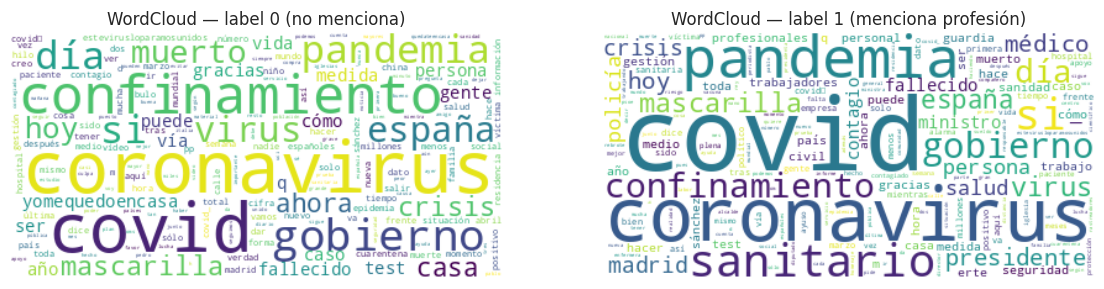

In [19]:
plt.figure(figsize=(14,6))

# label = 0
plt.subplot(1,2,1)
wc0 = wordcloud.generate(txt_cat0)
plt.imshow(wc0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud — label 0 (no menciona)")

# label = 1
plt.subplot(1,2,2)
wc1 = wordcloud.generate(txt_cat1)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud — label 1 (menciona profesión)")

plt.show()


## Tokenización

El texto del dataset no está preparado para ser introducido en un modelo Transformers. Lleva a cabo el proceso de tokenización.

In [20]:
# IMPORTS
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate, numpy as np


Selecciona un modelo apropiado para la tarea:

> Recuerda que en la siguiente celda sólo debes asignar un valor a model_name. No añadas más información en la celda.

In [21]:
#NO-MODIFY: VARIABLE NAME
model_name = 'cardiffnlp/twitter-xlm-roberta-base' # 或 'PlanTL-GOB-ES/roberta-base-bne'

为什么选它：这是面向 Twitter/社媒文本的多语 XLM-R 变体，能更好处理口语、emoji、错拼等；非常贴合你这份西语推文任务。

**Modelo elegido**: cardiffnlp/twitter-xlm-roberta-base

**Por qué**: Es una variante de XLM-R preentrenada específicamente en tweets (lenguaje informal, abreviaturas, hashtags, mentions, emojis y code-switching). Esto la hace muy adecuada para nuestro corpus de Twitter en español. El tokenizer está alineado con el preentrenamiento y, junto con un max_length basado en P95 de la longitud de los textos, reduce truncamientos innecesarios conservando rendimiento.

**Alternativa de comparación**: PlanTL-GOB-ES/roberta-base-bne, un RoBERTa en español (corpus de la BNE) útil como baseline monolingüe para ver el efecto del dominio (tweets vs. texto general).
Foco de evaluación: elegir el umbral por F1 en validación (clases desbalanceadas) y reportar precision/recall/F1.

Model cards:
• Twitter XLM-RoBERTa base — https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base

• RoBERTa-base-BNE (PlanTL-GOB-ES) — https://huggingface.co/PlanTL-GOB-ES/roberta-base-bne

Puedes continuar con el proceso aquí:

In [ ]:
# Crea el tokenizer y define max_length (usamos P95 de la longitud en caracteres del train)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 用训练集字符长度的 P95 作为上限，避免过度截断或显存浪费
len_train_chars = dataset_train_df['text'].astype(str).str.len().to_numpy()
max_length = int(np.percentile(len_train_chars, 95))
max_length = max(64, min(256, max_length))  # 给个合理边界（64~256）
print("max_length =", max_length)


max_length 是什么？

是 tokenizer 输出序列的目标长度。

短于这个长度的样本会被**补齐（padding）**到 max_length；

长于这个长度的样本会被**截断（truncation）**到 max_length。

同时会生成 attention_mask：真实 token=1、填充部分=0，模型据此忽略 padding。

影响

太小：很多文本被截断 → 丢信息 → F1 下降。

太大：显存占用和训练时间直线上升（复杂度 ~ O(seq_len²) 对于注意力）。

折中做法（推荐）：用训练集长度的 P95 当 max_length，再夹在一个理性范围（比如 64～256）。

覆盖 95% 的文本，不让尾部极端长文本拖慢训练。

PyTorch 张量（tensor）是什么？

是 PyTorch 的核心数据结构，类似 带类型+设备信息的多维数组（像升级版的 NumPy ndarray）。

属性：

dtype（数据类型，比如 torch.long、torch.float32）

device（在 CPU 还是 GPU，比如 cuda:0）

shape（维度，比如 [batch_size, max_length]）

在 Transformers 里：

set_format(type='torch', columns=[...]) 让 datasets 返回 张量，这样 Trainer 可以直接把它们送入 GPU 训练。

常见张量：

input_ids: LongTensor，形状 [batch, max_length]

attention_mask: LongTensor，同上

labels: LongTensor 或 FloatTensor（分类通常是 long）

In [ ]:
# dataset 是老师给的 HuggingFace Datasets 对象（含 train/validation/test）
def preprocess_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )

encoded = {}
for split in ["train", "validation", "test"]:
    d = dataset[split].map(preprocess_fn, batched=True)

    # Trainer 需要 'labels' 字段名；test 里不改，避免把 -1 当作真标签
    if "label" in d.column_names and split != "test":
        d = d.rename_columns({"label": "labels"})

    # 告诉 Datasets 以后要返回 pytorch 张量
    cols = ["input_ids", "attention_mask"]
    if "labels" in d.column_names:
        cols += ["labels"]
    d.set_format(type="torch", columns=cols)

    encoded[split] = d

encoded["train"][:2]  # 快速看下字段


一句话：把文本→token→张量，就是把数据做成模型“能吃”的形状与类型；set_format('torch', ...) 这步确保拿到的就是 PyTorch 张量，从而让 Trainer/模型在 GPU 上顺畅训练。

preprocess_fn 用 tokenizer 把文本变成整数序列：

input_ids: 每个 token 的词表索引（ints）。

attention_mask: 哪些位置是有效 token(1) / padding(0)。

dataset[split].map(...) 先得到的是 Python 列表 / NumPy 数组。

set_format(type="torch", columns=cols) 把这些列转换成 PyTorch 张量，这样：

取一条样本时，得到的是 torch.Tensor，而不是 list/ndarray。

Trainer 才能把它们直接送进模型、在 GPU 上跑、算梯度。

你这里每条样本的张量含义与形状（单样本）：

input_ids: LongTensor，形状 [max_length]（比如 160）。

attention_mask: LongTensor，形状 [max_length]（1/0）。

labels（仅 train/validation）: LongTensor，标注 0/1。

## Fine-tuning

Carga el model para ser ajustado posteriormente:

In [ ]:
# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


In [ ]:
from transformers import AutoModelForSequenceClassification

id2label = {0: "no_menciona", 1: "menciona_profesión"}
label2id = {"no_menciona": 0, "menciona_profesión": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=2, id2label=id2label, label2id=label2id)

In [25]:
print(model.config.id2label)
print(model.config.label2id)


{0: 'no_menciona', 1: 'menciona_profesión'}
{'no_menciona': 0, 'menciona_profesión': 1}


AutoModelForSequenceClassification：Hugging Face 的高层封装，会根据 model_name 自动选择合适的架构（比如 XLM-RoBERTa、RoBERTa、BERT…），并在顶层挂一个分类头（全连接层）。

.from_pretrained(model_name, num_labels=2)：

下载并加载 预训练主干（embedding + encoder）的权重；

同时创建一个输出维度为 2 的分类头，用来预测两个类别（0/1）。

这个分类头的参数是新初始化的（随机），需要在你的数据上微调。

你得到的 model：

前向输出是形状 [..., 2] 的 logits（每个样本两个分数）。

训练时会用 labels 计算交叉熵损失；推理时可对 logits 做 softmax 得到概率。

若 score_for_class_1 > score_for_class_0，argmax 选类 1 → 预测“提职业”。

经过 softmax：
P(y=1) = softmax(logits)[1]，你再用阈值（0.5 或你调到的 best_t≈0.78）把它变成 0/1。

### Configuracion training_args

Configura los parámetros de entrenamiento del modelo.


>

> Recuerda que en la siguiente celda sólo debes asignar atributos a la variable training_args. No añadas  otras variables en la celda

In [33]:
#NO-MODIFY: VARIABLE NAME
training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.1,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none",
    seed=42
)

In [32]:
#NO-MODIFY: VARIABLE NAME
# training_args = TrainingArguments(
#     output_dir="./out",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     num_train_epochs=3,
#     metric_for_best_model="f1",
#     report_to="none",
#     seed=42
# )


### Métricas de evaluación

Define las métricas de evaluación

In [34]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_value = f1.compute(predictions=predictions, references=labels, average="binary")["f1"]

    return {
        "accuracy": accuracy_value,
        "f1": f1_value
    }


argmax = “返回最大值的位置（索引）” 的函数。
常见于分类里：我们对每个样本有一行分数score（logits/概率），argmax 沿着“类别”这条轴取最大的那个类别编号。

NumPy：np.argmax(a, axis=...)

PyTorch：tensor.argmax(dim=...)

import numpy as np

# 两个样本、三类（Class 0/1/2）
```
logits = np.array([
    [0.2, 1.3, 0.5],   # 样本1：对三类的分数
    [2.1, 0.4, 0.3]    # 样本2：对三类的分数
])  # shape = (2, 3)


preds = np.argmax(logits, axis=-1)
print(preds)  # [1 0]

```

因为分类模型对每个类别都会输出一个“分数”（通常是 logits，过 softmax 就是概率）。
在0–1 代价下，理论上的最优决策（Bayes 决策）就是：选后验概率最大的那个类别。这正是 argmax 做的事。

### Ajuste del modelo

Lleva a cabo el ajuste del modelo:

In [35]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded['train'],
    eval_dataset=encoded['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()



/tmp/ipython-input-1155909850.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
50,0.176200,0.316872,0.910911,0.836096
100,0.108700,0.321029,0.932933,0.869903
150,0.118700,0.520201,0.898899,0.818671
200,0.117800,0.299634,0.938939,0.879208
250,0.066400,0.318523,0.943944,0.888000
300,0.082700,0.376424,0.933934,0.871595
350,0.039300,0.365877,0.929930,0.865385
400,0.028400,0.426567,0.922923,0.855535
450,0.045600,0.380888,0.934935,0.874759
500,0.069800,0.450251,0.918919,0.849722


TrainOutput(global_step=525, training_loss=0.08241831370762416, metrics={'train_runtime': 694.665, 'train_samples_per_second': 12.032, 'train_steps_per_second': 0.756, 'total_flos': 1099541100349440.0, 'train_loss': 0.08241831370762416, 'epoch': 3.0})

In [36]:

trainer.save_model("output_model_save")


## Evaluacion

Una vez llevada a cabo el entrenamiento, realiza la evaluación del modelo.

F1 score 看的是精确率（Precision）和召回率（Recall）的综合表现，用它们的调和平均衡量模型整体“既准又全”的程度。

In [37]:
eval_metrics = trainer.evaluate(encoded['validation'])
print(eval_metrics)

{'eval_loss': 0.4218849539756775, 'eval_accuracy': 0.923923923923924, 'eval_f1': 0.8571428571428571, 'eval_runtime': 12.0564, 'eval_samples_per_second': 82.86, 'eval_steps_per_second': 2.654, 'epoch': 3.0}


In [38]:
# —— Predict: 拿到 logits 与真实 labels
predictions = trainer.predict(encoded['validation'])
y_logits = predictions.predictions            # shape: [N, 2]
y_true   = predictions.label_ids              # shape: [N]

# —— 用 argmax 得到离散预测
import numpy as np
y_pred = np.argmax(y_logits, axis=-1)

# —— 报告
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=3))

[[695  66]
 [ 10 228]]
              precision    recall  f1-score   support

           0      0.986     0.913     0.948       761
           1      0.776     0.958     0.857       238

    accuracy                          0.924       999
   macro avg      0.881     0.936     0.903       999
weighted avg      0.936     0.924     0.926       999



你需要的三个 F1

F1@0.5（默认阈值）
compute_metrics 里 argmax/阈值0.5得到。主要用来训练过程监控。

F1@best_t（验证集最优阈值）
你用验证集扫阈值（比如 0.78）得到的 F1。这是更贴近业务目标的成绩。

测试集 F1（老师算）
你提交 TSV 后，老师用隐藏真值算。我们自己是看不到的。

最后该“用哪个 F1”写进报告 / 选模型？

选模型与生成提交：

用 load_best_model_at_end=True + metric_for_best_model="f1" 固定最优检查点；

用你找到的 best_t 作为最终阈值去预测 test。

报告展示：两者都给，但以 F1@best_t 为主：

报告表格写：F1@0.5 和 F1@best_t(=0.78)（精确率/召回也一并给）；

明确说明：“提交文件用的阈值 = best_t（0.78）”。

理由：评分看测试集 F1，而你无法在测试集调阈值；在验证集用 best_t 能更好平衡 P/R，通常带来更高的测试 F1。默认 0.5 只作为参考基线。

用 torch.softmax 是把logits（原始分数）变成概率，因为你下面要做“概率 ≥ 阈值 → 1，否则 0”的判定并扫阈值求最优 F1。

In [39]:
import numpy as np
import torch
from sklearn.metrics import f1_score

# 用 Trainer 统一拿出 logits 和真实标签
pred_out   = trainer.predict(encoded['validation'])
val_logits = pred_out.predictions           # shape: [N, 2]
val_labels = pred_out.label_ids             # numpy array, shape: [N]

# 提到职业的概率（取正类, y=1）
val_probs = torch.softmax(torch.tensor(val_logits), dim=-1)[:, 1].numpy()

# 扫描阈值，找 F1 最优
best_t, best_f1 = 0.5, -1
for t in np.linspace(0.2, 0.8, 31):
    f1 = f1_score(val_labels, (val_probs >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Best threshold:", best_t, "Best F1:", best_f1)


Best threshold: 0.76 Best F1: 0.8647619047619047


## Genera predicciones

Genera predicciones sobre el test set. Recuerda que el archivo que generes y adjuntes al ejercicio debe tener dos columnas:


| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo debe estar en formato **TSV** (separado por tabuladores).
- Debe contener exactamente **dos columnas**: `id` y `label`.
- Es obligatorio incluir la **cabecera**.


用当前模型在 test 集上前向推理，拿到每条样本对两个类别的原始分数（logits）。形状是 [N, 2]。

把 logits 经过 softmax 变成概率；dim=-1 表示沿“最后一维=类别维”做归一化。

[:, 1] 取第 1 列 = P(y=1)（“提到职业”的概率）。

.numpy() 转成 NumPy 数组，方便后续处理。

设定判定阈值：如果你前面已经通过验证集网格搜索得到 best_t，就用它；否则回退到 0.5。globals() 是 Python 的全局符号表（一个字典），包含当前笔记本/脚本里已定义的全局变量。


test_probs >= threshold：对每个样本做比较，得到 布尔数组，只会是 True 或 False。

.astype(int)：把布尔值转成整数，True→1，False→0。

test_probs 来自 softmax（0~1 之间），threshold 是你设的阈值（如 0.52），所以比较结果只会落在两个阵营：≥阈值（正类=1）或 <阈值（负类=0）。

In [55]:
import pandas as pd, torch, numpy as np

test_logits = trainer.predict(encoded['test']).predictions
test_probs  = torch.softmax(torch.tensor(test_logits), dim=-1)[:,1].numpy()

threshold = best_t if 'best_t' in globals() else 0.5
test_pred  = (test_probs >= threshold).astype(int)

out = pd.DataFrame({"id": dataset['test']['tweet_id'], "label": test_pred})

FILENAME = "Wenxi_Gu_ejercicio1_predicciones.tsv"
out.to_csv(FILENAME, sep="\t", index=False)
print("Saved:", FILENAME, "shape:", out.shape)
out.head()


Saved: Wenxi_Gu_ejercicio1_predicciones.tsv shape: (1001, 2)


,id,label
0,1277969650051997701,1
1,1263161378627600385,0
2,1255919996779315208,0
3,1282361712117780486,0
4,1267872916009615364,0
